In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import sympy as sp
from sympy import *
import math
import re



with open("equation.txt") as f:
    for line in f:
        e = line #e is the equation

#pe is the proper equation format in np
pe = e

functions = ['sin', 'cos', 'tan', 'exp', 'log', 'sqrt']

for f in functions:
    pe = re.sub(rf'\b{f}\b', f'np.{f}', pe)
pe = pe.replace('^', '**')

se = pe.replace('np.', '')

print(e)
print(pe)
print(se)

def make_function(ex): #pe
    allowed_names = {
        'np': np,
        'x': None  # placeholder, replaced at call time
    }

    def f(x):
        local_dict = allowed_names.copy()
        local_dict['x'] = x
        return eval(ex, {"__builtins__": {}}, local_dict)

    return f



sin(x)
np.sin(x)
sin(x)


In [59]:
x = sp.symbols('x')
f = sp.sympify(se)

def findTaylor(times):
    taylors = f.subs(x,0)
    diffed = f
    for i in range(1, times):
        diffed = diffed.diff(x)
        taylors += diffed.subs(x,0) * 1/(factorial(i))*(x**i)
    return taylors

print(findTaylor(25))

-x**23/25852016738884976640000 + x**21/51090942171709440000 - x**19/121645100408832000 + x**17/355687428096000 - x**15/1307674368000 + x**13/6227020800 - x**11/39916800 + x**9/362880 - x**7/5040 + x**5/120 - x**3/6 + x


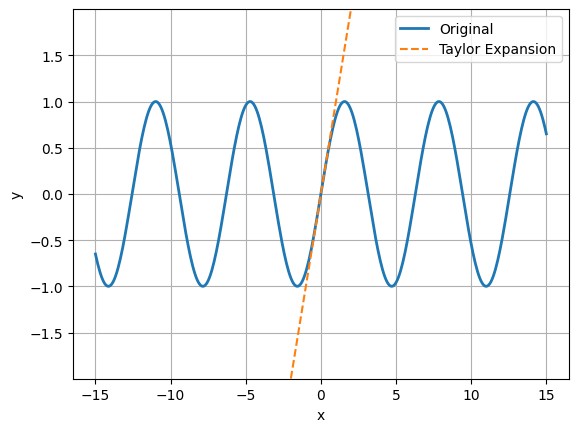

In [60]:
from matplotlib.widgets import Slider

def update_plot(val):
    taylor_np = sp.lambdify(x, findTaylor(val), "numpy")


original_function = make_function(pe) #The Original
taylor_np = sp.lambdify(x, findTaylor(2), "numpy") #Taylor's Theorem


#x and y values of the plotted lines
x_vals = np.linspace(-15, 15, 400)

y_np = original_function(x_vals)
y_sym = taylor_np(x_vals)

plt.figure()
plt.plot(x_vals, y_np, label="Original", linewidth=2)
plt.plot(x_vals, y_sym, label="Taylor Expansion", linestyle="--")


#makes y of the graph capped
padding = 0.5

y_min = np.nanmin(y_np)
y_max = np.nanmax(y_np)

yrange = y_max - y_min

plt.ylim(
    y_min - padding * yrange,
    y_max + padding * yrange
)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()
